# Notebook description

We know the noise properties for a synapse receiving [Poisson](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_poisson.ipynb) and [uniform](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_uniform.ipynb) spikes. This notebook examines the noise properties for a synapse receiving the weighted combination of spike trains. This setup is the present in NEF when reading out decoded values or passing decoded values between populations. 

Specifically, we're looking to answer
 - how does the variance of the synapse depend on the input spike rate and decoding weights?

# Summary of results

The synaptic variance will be

\begin{align}
\operatorname{Var}(X) &= \sum_i^Nd_i^2\operatorname{Var}(X_i) \\
\end{align}

For [uniform](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_uniform.ipynb) input spikes (as with LIF neurons),

\begin{align}
\operatorname{Var}(X_i) &= \lambda_i^2\left(\frac{1}{2\lambda_i\tau}\coth\left(\frac{1}{2\lambda_i\tau}\right)-1\right) \\
\operatorname{Var}(X_i) &\approx \frac{1}{12\tau^2} \\
\end{align}

# Analysis

Consider a synapse with impulse response $h(t)$ receiving $N$ spike trains as each spiking at rate $\lambda_i$ and scaled by $d_i$. In NEF, these spike trains would typicaly be produced by LIF neurons.

![weighted spike trains converging on a synapse](figures/ensemble_in.png "weighted spike trains converging on a synapse")

Since the synapse has linear, first order dynamics, it can be described by the superposition of synaptic responses to the individual $N$ spike trains. That is,

$$x(t) = \sum_i^N x_i(t)$$

where

$$x_i(t) = \sum_jh(t-t_{i,j})$$

where $t_{i,j}$ is the time of the $j$th spike of the $i$th spike train which has rate $\lambda_i$.

To understand the noise observed in $x(t)$, we can start with the basics of random variables. For indepedent random variables $X$ and $Y$,

$$\operatorname{Var}(X+Y) = \operatorname{Var}(X)+\operatorname{Var}(Y)$$

For scalar $d$

$$\operatorname{Var}(dX) = d^2\operatorname{Var}(X)$$

Therefore, for a synapse receiving the sum of weighted spikes, if we declare $x(t)=X$, 

\begin{align}
\operatorname{Var}(X) &= \sum_i^Nd_i^2\operatorname{Var}(X_i) \\
\end{align}

If we're using LIF neurons, which spike uniformly for constant input,

\begin{align}
\operatorname{Var}(X_i) &= \lambda_i^2\left(\frac{1}{2\lambda_i\tau}\coth\left(\frac{1}{2\lambda_i\tau}\right)-1\right) \\
\operatorname{Var}(X_i) &\approx \frac{1}{12\tau^2} \\
\end{align}

as derived [here](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_uniform.ipynb), where
 - $\lambda_i$ is the $i$th neuron's spike rate, and
 - $\tau$ is the synaptic time constant

Keep in mind that this assumes the $N$ spike trains are independent. Be sure to check whether this is true.

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import nengo
from nengo.dists import Uniform

from utils.synapse_ensemble_noise import (
    build_net, check_decode_var, var_exp_sweep_u, var_exp_sweep_rates, rate_vs_var)
from neuron.utils.plot import make_blue_cmap, make_red_cmap, make_color_cycle
from utils.synapse import th_u_var

bcmap = make_blue_cmap()
rcmap = make_red_cmap()

# Simulation

How well does the variance predicted with the independent, uniform spike rate assumption match to the observed variance?

observed  decode variance 3.287115e-04
decoders * rates variance 3.287115e-04
estimated decode variance 3.151747e-04 (from observed rates)
predicted decode variance 3.179424e-04 (from theoretical rates, assume uniform spikes)
predicted decode variance 3.767958e-03 (from theoretical rates, assume Poisson spikes)
relative variance error   3.276150e-02 (observed variance vs var predicted from decoding uniform rates)

observed  decode std 1.813040e-02
decoders * rates std 1.813040e-02
estimated decode std 1.775316e-02 (from observed rates)
predicted decode std 1.783094e-02 (from theoretical rates, assuming uniform spikes)
predicted decode std 6.138369e-02 (from theoretical rates, assuming Poisson spikes)
relative std error   1.651716e-02 (observed std vs std predicted from decoding uniform rates)


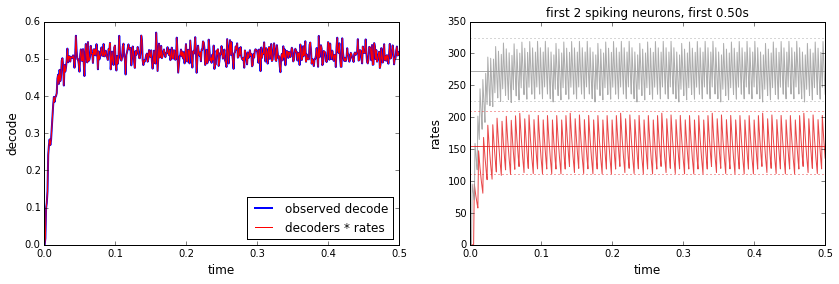

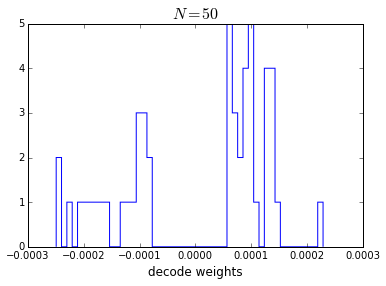

In [52]:
dt = 1e-3
T = 1.
N = 50
u = .5
tau = .01
check_decode_var(dt, T, N, u, tau)

How well does the variance change across the input space? How do the mean and total firing rates change across the input space?

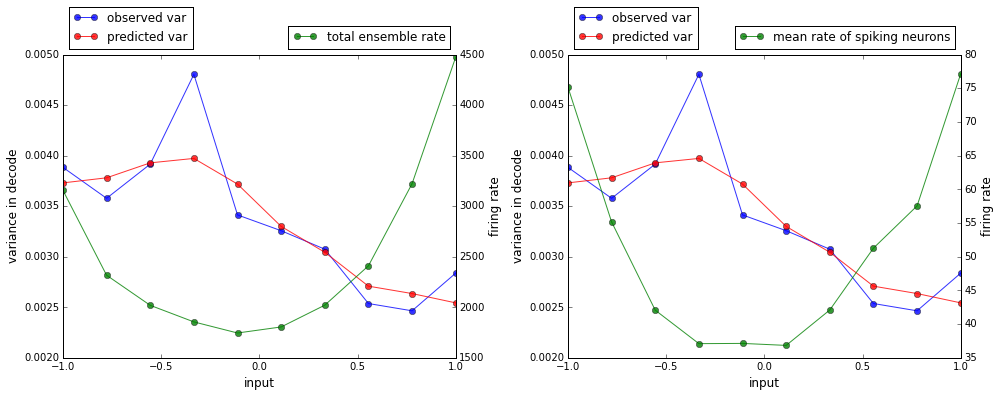

In [35]:
T = 2.
N = 100
tau = .01
u = np.linspace(-1, 1, 10)

net = build_net(N=N, tau=tau, max_rates=Uniform(50,100))
total_rates, mean_rates, var_decodes, th_var_decodes = var_exp_sweep_u(T=T, N=N, tau=tau, u=u, net=net)
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
axs[0].plot(u, var_decodes, 'b-o', alpha=.8, label='observed var')
axs[0].plot(u, th_var_decodes, 'r-o', alpha=.8, label='predicted var')
axs[0].legend(loc='lower left', bbox_to_anchor=(0, 1.))
axs[0].set_xlabel('input', fontsize=12)
axs[0].set_ylabel('variance in decode', fontsize=12)
ax = axs[0].twinx()
ax.plot(u, total_rates, 'g-o', alpha=.8, label='total ensemble rate')
ax.legend(loc='lower right', bbox_to_anchor=(1., 1.))
ax.set_ylabel('firing rate', fontsize=12)

axs[1].plot(u, var_decodes, 'b-o', alpha=.8, label='observed var')
axs[1].plot(u, th_var_decodes, 'r-o', alpha=.8, label='predicted var')
axs[1].legend(loc='lower left', bbox_to_anchor=(0, 1.))
axs[1].set_xlabel('input', fontsize=12)
axs[1].set_ylabel('variance in decode', fontsize=12)
ax = axs[1].twinx()
ax.plot(u, mean_rates, 'g-o', alpha=.8, label='mean rate of spiking neurons')
ax.legend(loc='lower right', bbox_to_anchor=(1., 1.))
ax.set_ylabel('firing rate', fontsize=12)
plt.tight_layout()

Variance seems somewhat related to the total firing rate and mean firing rates. If we sweep across a larger range of rates, will we see a stronger trend?

In [2]:
T = 1.
N = 100
tau = .01
u = np.linspace(-1, 1, 10)
max_rates = [Uniform(12, 25), Uniform(25, 50), Uniform(50, 100), Uniform(100, 200), 
              Uniform(200, 400)]

total_rates, mean_rates, var_decodes, th_var_decodes = var_exp_sweep_rates(T=T, N=N, tau=tau, u=u, max_rates=max_rates)
total_rates = np.array(total_rates)
mean_rates = np.array(mean_rates)

First using the mean rates.

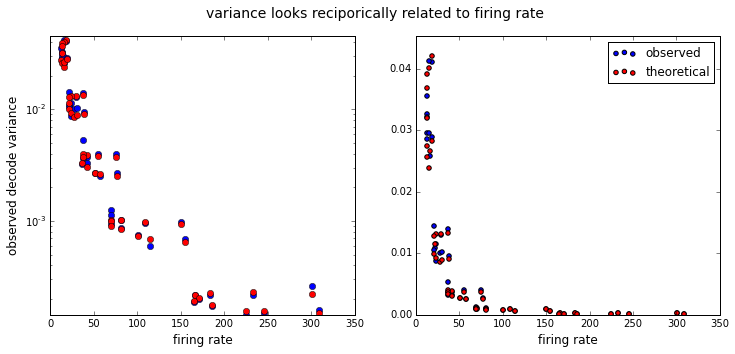

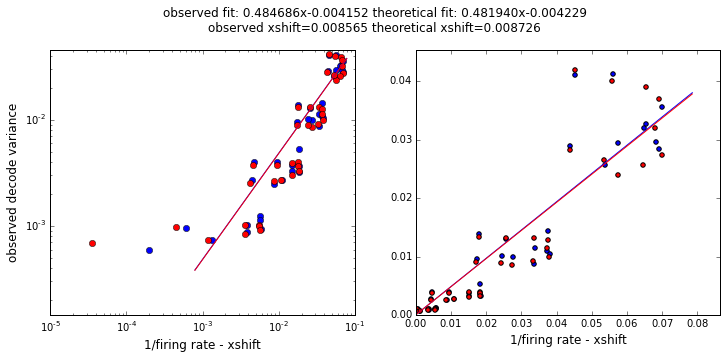

In [3]:
rate_vs_var(mean_rates, var_decodes, th_var_decodes)

The decode variance looks like it has close to a $1/$mean firing rate relationship. The fit is not perfect as indicated by the offset, but it's pretty close.

Now using the total rates.

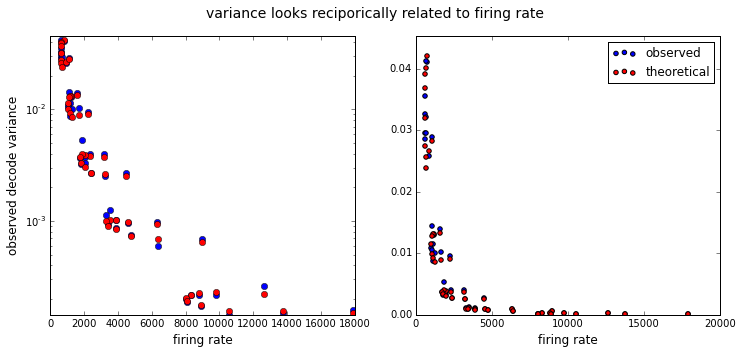

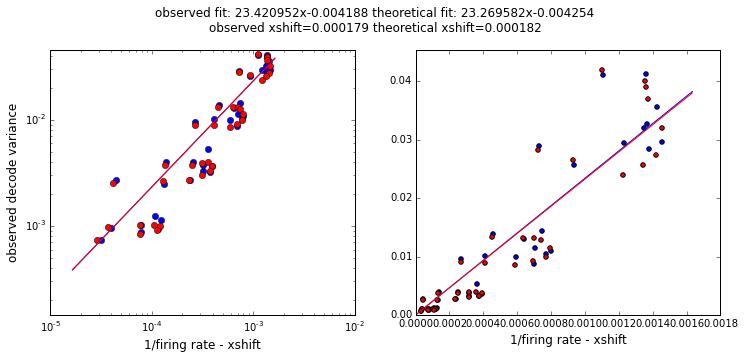

In [4]:
rate_vs_var(total_rates, var_decodes, th_var_decodes)

In [ ]:
def build_net_mse(mse, min_n_neurons=32, ensemble_p={}):
    net = build_net(min_n_neurons, **ensemble_p)
    sim = nengo.Simulator(net)
    

# Appendix

How do decode wieghts drop with number of neurons? with total firing rate?

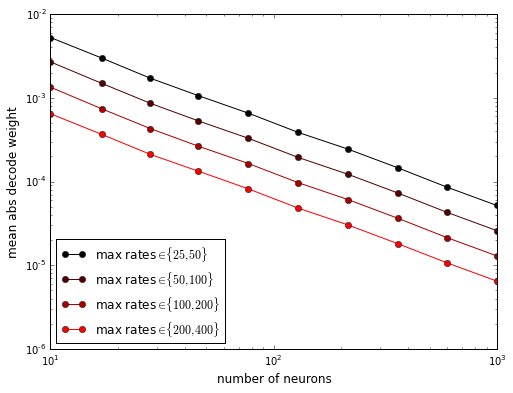

In [38]:
k = 10
N_vals = np.round(np.logspace(1, 3, k)).astype(int)
hl_max_rates = [(25, 50), (50, 100), (100, 200), (200, 400)]
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('number of neurons', fontsize=12)
ax.set_ylabel('mean abs decode weight', fontsize=12)
ax.set_color_cycle(make_color_cycle(len(hl_max_rates), rcmap))
for hl in hl_max_rates:
    mean_decoders = np.zeros(k)
    for idx, N in enumerate(N_vals):
        net = build_net(N=N, max_rates=Uniform(*hl))
        sim = nengo.Simulator(net)
        mean_decoders[idx] = np.mean(np.abs(sim.data[net.conn].decoders))
    ax.loglog(N_vals, mean_decoders, '-o', label=r'max rates$\in\{%.0f, %.0f\}$' % (hl[0], hl[1]))
ax.legend(loc='lower left');

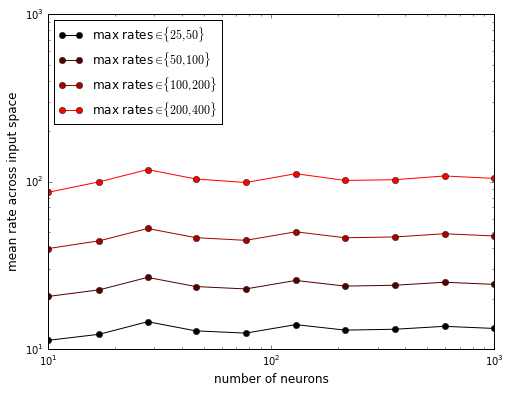

In [4]:
k = 10
N_vals = np.round(np.logspace(1, 3, k)).astype(int)
hl_max_rates = [(25, 50), (50, 100), (100, 200), (200, 400)]
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('number of neurons', fontsize=12)
ax.set_ylabel('mean rate across input space', fontsize=12)
ax.set_color_cycle(make_color_cycle(len(hl_max_rates), rcmap))
for hl in hl_max_rates:
    mean_rates = np.zeros(k)
    for idx, N in enumerate(N_vals):
        net = build_net(N=N, max_rates=Uniform(*hl))
        sim = nengo.Simulator(net)
        _, activities = nengo.utils.ensemble.tuning_curves(net.ens, sim)
        mean_rates[idx] = np.mean(activities)
    ax.loglog(N_vals, mean_rates, '-o', label=r'max rates$\in\{%.0f, %.0f\}$' % (hl[0], hl[1]))
ax.legend(loc='upper left');